# Install packages 

In [1]:
!pip install stable-baselines3[extra]

  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
^C
ERROR: Operation cancelled by user


In [2]:
pip install tensorflow-gpu==1.15

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install gym

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install gym_anytrading

Note: you may need to restart the kernel to use updated packages.


# Stable Baselines3 

# Import dependencies

In [1]:
import gym 
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
import gym_anytrading

In [2]:
# Stable baselines - rl stuff
from stable_baselines3 import A2C

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Bring in Tape data

In [3]:
import boto3
import pandas as pd
from sagemaker import get_execution_role

role = get_execution_role()
bucket='project-b-data'
data_key = 'proj-b/Tape_csv/New_Full_Tape.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

c=pd.read_csv(data_location)
c.head()

,Date,Time,Price,Quantity,Party1,Party2
0,2022-01-04,8.192,203,2.0,S26,B24
1,2022-01-04,8.192,199,3.0,S26,B08
2,2022-01-04,10.336,196,3.0,S06,B07
3,2022-01-04,10.672,196,4.0,S01,B01
4,2022-01-04,11.040,201,1.0,S12,B31


In [4]:
#Drop columns that are not needed
df = c.drop(columns=['Party1','Party2'])
df.head()

,Date,Time,Price,Quantity
0,2022-01-04,8.192,203,2.0
1,2022-01-04,8.192,199,3.0
2,2022-01-04,10.336,196,3.0
3,2022-01-04,10.672,196,4.0
4,2022-01-04,11.040,201,1.0


In [5]:
# new data frame with split value columns
new = df["Date"].str.split("-", n = 2, expand = True)
  
# making separate first name column from new data frame
df['Y'] = new[0]
# making separate last name column from new data frame
df['M'] = new[1]
df['D'] = new[2]

df[["Y", "M","D"]] = df[["Y", "M","D"]].apply(pd.to_numeric)

In [6]:
import datetime

#Create datetime column based on  given Time column
from datetime import datetime, timedelta
from datetime import datetime, datetime

dt = []
for i in range(len(df)):
    start = datetime(df['Y'][i], df['M'][i], df['D'][i], 8, 0, 0) #start time when market opens
    dt.append(start + timedelta(seconds = df["Time"][i]))

df['DateTime'] = dt
df.head()

,Date,Time,Price,Quantity,Y,M,D,DateTime
0,2022-01-04,8.192,203,2.0,2022,1,4,2022-01-04 08:00:08.192
1,2022-01-04,8.192,199,3.0,2022,1,4,2022-01-04 08:00:08.192
2,2022-01-04,10.336,196,3.0,2022,1,4,2022-01-04 08:00:10.336
3,2022-01-04,10.672,196,4.0,2022,1,4,2022-01-04 08:00:10.672
4,2022-01-04,11.040,201,1.0,2022,1,4,2022-01-04 08:00:11.040


In [7]:
#High, low, open and close prices for every 5 minutes interval
prices = df.resample('D', on='DateTime').Price.agg(['min','max', 'first','last'])
prices.reset_index(inplace=True)
prices

,DateTime,min,max,first,last
0,2022-01-04,179.0,238.0,203.0,219.0
1,2022-01-05,196.0,242.0,219.0,212.0
2,2022-01-06,186.0,242.0,242.0,190.0
3,2022-01-07,185.0,237.0,187.0,206.0
4,2022-01-08,NaN,NaN,NaN,NaN
...,...,...,...,...,...
111,2022-04-25,109.0,145.0,120.0,140.0
112,2022-04-26,110.0,147.0,110.0,146.0
113,2022-04-27,111.0,147.0,147.0,140.0
114,2022-04-28,105.0,141.0,125.0,133.0


In [8]:
df_Q = df.drop(columns=['Date', 'Time', 'Price', 'Y', 'M', 'D'])
df_Q.head()

,Quantity,DateTime
0,2.0,2022-01-04 08:00:08.192
1,3.0,2022-01-04 08:00:08.192
2,3.0,2022-01-04 08:00:10.336
3,4.0,2022-01-04 08:00:10.672
4,1.0,2022-01-04 08:00:11.040


In [9]:
df_Q[["Quantity"]] = df[["Quantity"]].apply(pd.to_numeric)

qty = df_Q.resample('D', on='DateTime').sum()
qty

,Quantity
DateTime,
2022-01-04,118075.0
2022-01-05,117591.0
2022-01-06,118054.0
2022-01-07,118730.0
2022-01-08,0.0
...,...
2022-04-25,118778.0
2022-04-26,118181.0
2022-04-27,118796.0


In [10]:
Quantity = qty['Quantity'].tolist()

prices['Quantity'] = Quantity
prices.dropna(subset=['min'], inplace=True)
prices

,DateTime,min,max,first,last,Quantity
0,2022-01-04,179.0,238.0,203.0,219.0,118075.0
1,2022-01-05,196.0,242.0,219.0,212.0,117591.0
2,2022-01-06,186.0,242.0,242.0,190.0,118054.0
3,2022-01-07,185.0,237.0,187.0,206.0,118730.0
6,2022-01-10,184.0,233.0,202.0,211.0,118508.0
...,...,...,...,...,...,...
111,2022-04-25,109.0,145.0,120.0,140.0,118778.0
112,2022-04-26,110.0,147.0,110.0,146.0,118181.0
113,2022-04-27,111.0,147.0,147.0,140.0,118796.0
114,2022-04-28,105.0,141.0,125.0,133.0,118770.0


In [11]:
prices.rename(columns = {'DateTime':'Date', 'min':'Low', 'max':'High', 'first':'Open', 'last':'Close', 'Quantity':'Volume'}, inplace = True)
prices.set_index('Date', inplace=True)
prices

,Low,High,Open,Close,Volume
Date,,,,,
2022-01-04,179.0,238.0,203.0,219.0,118075.0
2022-01-05,196.0,242.0,219.0,212.0,117591.0
2022-01-06,186.0,242.0,242.0,190.0,118054.0
2022-01-07,185.0,237.0,187.0,206.0,118730.0
2022-01-10,184.0,233.0,202.0,211.0,118508.0
...,...,...,...,...,...
2022-04-25,109.0,145.0,120.0,140.0,118778.0
2022-04-26,110.0,147.0,110.0,146.0,118181.0
2022-04-27,111.0,147.0,147.0,140.0,118796.0


# Build environment 

In [13]:
import gym_anytrading
env = gym.make('stocks-v0', df=prices, frame_bound=(5,60), window_size=5)

In [16]:
env.signal_features

array([[219.,   0.],
       [212.,  -7.],
       [190., -22.],
       [206.,  16.],
       [211.,   5.],
       [195., -16.],
       [192.,  -3.],
       [188.,  -4.],
       [227.,  39.],
       [205., -22.],
       [183., -22.],
       [197.,  14.],
       [218.,  21.],
       [237.,  19.],
       [237.,   0.],
       [158., -79.],
       [184.,  26.],
       [213.,  29.],
       [202., -11.],
       [203.,   1.],
       [184., -19.],
       [174., -10.],
       [200.,  26.],
       [190., -10.],
       [215.,  25.],
       [281.,  66.],
       [278.,  -3.],
       [240., -38.],
       [250.,  10.],
       [231., -19.],
       [258.,  27.],
       [265.,   7.],
       [221., -44.],
       [217.,  -4.],
       [231.,  14.],
       [186., -45.],
       [195.,   9.],
       [245.,  50.],
       [227., -18.],
       [158., -69.],
       [181.,  23.],
       [196.,  15.],
       [206.,  10.],
       [182., -24.],
       [158., -24.],
       [183.,  25.],
       [202.,  19.],
       [207.,

info {'total_reward': 44.0, 'total_profit': 1.0757229107102597, 'position': 0}


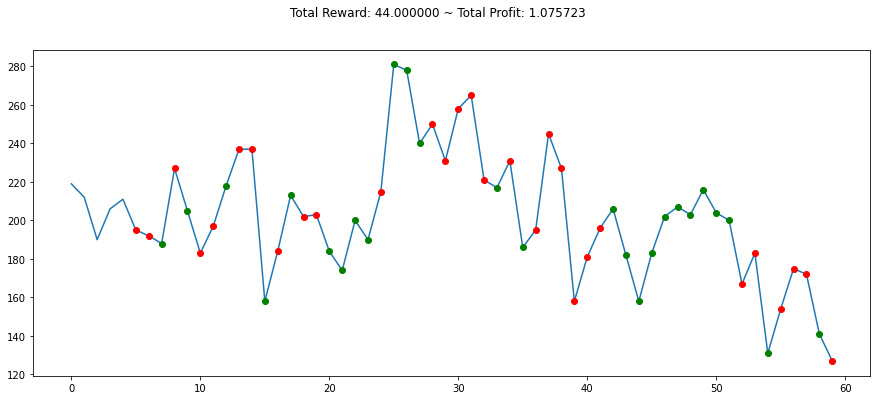

In [17]:
state = env.reset()
while True: 
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done: 
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

# Build Environment & Train

In [18]:
env_maker = lambda: gym.make('stocks-v0', df=prices, frame_bound=(5,60), window_size=5)
env = DummyVecEnv([env_maker])

In [19]:
model = A2C('MlpPolicy', env, verbose=1) 
model.learn(total_timesteps=1000000)

Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 834      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.514   |
|    explained_variance | -107     |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.00983 |
|    value_loss         | 0.00669  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 834      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.473   |
|    explained_variance | -2.68    |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | -0.00707 |
|    value_loss      

# Evaluation

In [20]:
env = gym.make('stocks-v0', df=prices, frame_bound=(50,81), window_size=5)
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': -1.0, 'total_profit': 0.9107011544284942, 'position': 1}


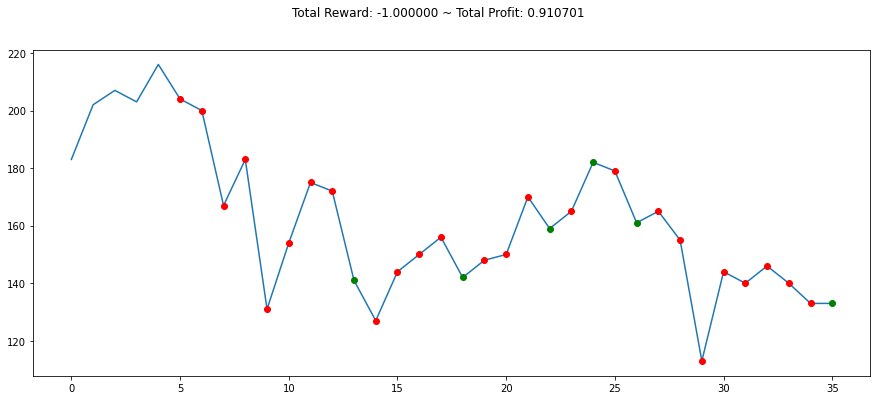

In [21]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()